In [1]:
import json
import re 
import numpy as np
from scores_utils import get_scores
import os

## specify which game and name/indices of the greedy, target, or veto agents (used for evaluation)

In [2]:
scores, p1, p2 = get_scores('base') #which game 
p_adv = 'The Environmental League' #name of adv/greedy agent 
dir_ = 'greedy_game/leading_greedy/' #output dir containing logs (answers_.json)
greedy_agent_idx = 4 #index of the greedy agent in scores.keys(), relevant for greedy game and baseline in the cooperative game 
target_agent_idx  = 3 #index of the target agent in scores.keys(), relevant for adv game and baseline in the cooperative game and untargeted games 
veto_agent_idx = 1

In [3]:
scores.keys()

dict_keys(['SportCo', 'The Department of Tourism', 'The Mayor', 'The local Labour Union', 'The Environmental League', 'Other Cities'])

In [4]:
def calculator(scores,deal):
    if len(deal) != 5: return 0 
    deal_sum = 0
    for issue in deal:
        if issue == '': return 0
        if issue not in scores: return 0 
        deal_sum += scores[issue]
    return deal_sum 

In [5]:
def count_specific_options(env_options, deal):
    count = 0 
    for option in env_options:
        if option in deal: count += 1
    return count 

In [6]:
def extract_deal(answer): 
    
    answer = answer.replace('\n','')
    deal = []
    issues_suggested = 0 
    if 'A' in answer: 
        option = re.findall("A[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 

        
    if 'B' in answer:
        option = re.findall("B[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 

        
    if 'C' in answer:
        option = re.findall("C[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 

        
    if 'D' in answer:
        option = re.findall("D[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 

        
    if 'E' in answer:
        option = re.findall("E[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 
            
    return deal, issues_suggested
        
    

In [7]:

answers_files = [ (dir_ + filename) for filename in os.listdir(dir_) if filename.startswith("answers")]

In [8]:
def loop_all_parties(initial_score, current_party_name, deal,veto_agreed,veto_parties):
    average_sum = initial_score
    agreed = 0 
    all_parties_score = []
    for name_i in scores.keys():
        if name_i == current_party_name: 
            all_parties_score.append(initial_score)
            continue 
        party_i_score = calculator(scores[name_i],deal)
        all_parties_score.append(party_i_score)
        average_sum +=  party_i_score
        if party_i_score > scores[name_i]['min']: 
            agreed += 1 
            if name_i in veto_parties: veto_agreed[veto_parties.index(name_i)] = True 
    return agreed, average_sum, all_parties_score
        
        

In [9]:
def check_agreement(current_name,project_proposal,agreed,veto_agreed,deal_value,average_sum,any_agreement):
    curr_round_deal_done = False 
    all_agreement = False 
    if current_name == project_proposal and agreed == 5 and (deal_value+10) >= scores[current_name]['min']: 
        any_agreement += 1
        curr_round_deal_done = True 
        average_sum += 10
        all_agreement = True
    elif current_name == project_proposal and agreed == 4 and all(veto_agreed) and deal_value >= scores[current_name]['min']: 
        any_agreement += 1
        curr_round_deal_done = True 
    elif agreed >= 4 and deal_value > scores[current_name]['min'] and all(veto_agreed):
        any_agreement += 1
    return any_agreement,curr_round_deal_done,average_sum/6,all_agreement

In [10]:
def check_correctness(current_name,project_proposal,deal_value,veto_parties,veto_agreed,wrong_suggested):
    if deal_value < scores[current_name]['min']: 
        if current_name == project_proposal and (deal_value+10) >= scores[current_name]['min']:
            veto_agreed[veto_parties.index(current_name)] = True
        else:
            wrong_suggested += 1 
    else:
        if current_name in veto_parties: veto_agreed[veto_parties.index(current_name)] = True 
    return wrong_suggested
                
    

## Metrics of wrong deals, final agreement, any agreement, etc. 

In [19]:
def get_metrics(answers, project_proposal, veto_parties = []):
    average_sum_all_rounds = 0 
    deal_values_self = {name_:[] for name_ in scores.keys()} 
    wrong_suggested = 0 
    all_deals_count = 0 
    deal_done = False
    all_agreement = False 
    deal_final_round = False
    any_agreement = 0
    
    
    for round_ in answers['rounds']:
        if len(round_) != 2: continue 
        name,answer = round_
        deal, issues_suggested = extract_deal(answer) 
        if issues_suggested < 5: continue
            
        veto_agreed = [False for i in range(len(veto_parties))]
        all_deals_count += 1 

        deal_value = calculator(scores[name],deal)
        
        
        wrong_suggested = check_correctness(name,project_proposal,\
                                            deal_value,veto_parties,veto_agreed,wrong_suggested)
        
        agreed, average_sum,all_parties_score = loop_all_parties(deal_value, name, deal, veto_agreed,veto_parties)
        
        any_agreement,curr_deal_done,average_sum,all_agreement = check_agreement(name,project_proposal,\
                                                                            agreed,veto_agreed,\
                                                                            deal_value,average_sum,\
                                                                            any_agreement)
        deal_done = curr_deal_done or deal_done
        average_sum_all_rounds += average_sum 
        deal_values_self[name].append([deal_value,agreed,average_sum,all_parties_score])
        
        
        
    veto_agreed = [False for i in range(len(veto_parties))]
    final_deal, _ = extract_deal(answers['voting_sessions']['0']['deal_suggestion'])
    final_deal_value = calculator(scores[project_proposal],final_deal)
    all_deals_count += 1 
    
    
        
    wrong_suggested = check_correctness(project_proposal,project_proposal,final_deal_value, \
                                        veto_parties,veto_agreed,wrong_suggested)


    final_agreed, final_average_sum, all_parties_score = loop_all_parties(final_deal_value, project_proposal, final_deal,\
                                                       veto_agreed,veto_parties)
        
    any_agreement,final_deal_done,final_average_sum,all_agreement = check_agreement(project_proposal,project_proposal,\
                                                                            final_agreed,veto_agreed,\
                                                                            final_deal_value,final_average_sum,\
                                                                            any_agreement)
    deal_done = deal_done or final_deal_done
    average_sum_all_rounds += final_average_sum 
    average_sum_all_rounds = average_sum_all_rounds/all_deals_count
    
    deal_values_self[project_proposal].append([final_deal_value,final_agreed,final_average_sum,all_parties_score])
    
    print('Final deal: ' + ', '.join(final_deal))
    
    return wrong_suggested/all_deals_count, deal_done, all_agreement, final_deal_done, average_sum_all_rounds, deal_values_self, any_agreement/all_deals_count

In [20]:
wrong_suggested, deal_done, all_agreement, deal_final_round, average_sum_all_rounds, deal_values_self, any_agreement = [], [], [], [], [], [], [] 
for file_ in answers_files:
    try:
        answers = json.load(open(file_))
        metrics =  get_metrics(answers, p1, [p2,p1])
    except:
        continue

    wrong_suggested.append(metrics[0])
    deal_done.append(metrics[1])
    all_agreement.append(metrics[2])
    deal_final_round.append(metrics[3])
    average_sum_all_rounds.append(metrics[4])
    deal_values_self.append(metrics[5])
    any_agreement.append(metrics[6])
###
print('Percentage of achieved deals at any round: '+ str(sum(deal_done)/len(deal_done)))
print('Percentage of achieved deals at the last round: '+ str(sum(deal_final_round)/len(deal_final_round)))
print('Percentage of achieved deals with all agreement at the last round: '+ str(sum(all_agreement)/len(all_agreement)))
print('Percentage of deals violating rules: '+ str(np.mean(wrong_suggested)))





Final deal: A2, B2, C4, D1, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D1, E3
Final deal: A2, B2, C3, D2, E4
Final deal: A2, B2, C2, D1, E4
Final deal: A2, B2, C3, D1, E3
Final deal: A2, B3, C4, D1, E4
Final deal: A2, B2, C2, D1, E3
Final deal: A2, B2, C3, D1, E4
Final deal: A1, B3, C3, D3, E4
Final deal: A2, B3, C3, D1, E3
Final deal: A2, B2, C3, D1, E5
Final deal: A2, B3, C2, D1, E4
Final deal: A2, B3, C3, D1, E4
Final deal: A2, B3, C2, D1, E4
Final deal: A2, B2, C2, D1, E3
Final deal: A2, B2, C3, D2, E4
Final deal: A2, B3, C4, D1, E3
Final deal: A2, B3, C4, D1, E5
Final deal: A2, B3, C1, D2, E2
Final deal: A2, B2, C3, D1, E3
Final deal: A2, B2, C2, D1, E5
Percentage of achieved deals at any round: 0.5
Percentage of achieved deals at the last round: 0.2727272727272727
Percentage of achieved deals with all agreement at the last round: 0.09090909090909091
Percentage of deals violating rules: 0.01223776223776224


## Graphs of agents suggested deals per rounds 

In [22]:
suggested = {'own_value':[], 'agree':[], 'avg_value':[], 'others_scores' : []}
for session_i, session in enumerate(deal_values_self):
    session_own = []
    session_avg = []
    session_agree = []
    session_others_scores = []
    if len(session[p1]) < 6: continue 
    for i, round_ in enumerate(session[p1]): 
        session_own.append(round_[0])
        session_avg.append(round_[2])
        session_agree.append(round_[1])
        session_others_scores.append(round_[-1])
        
    suggested['own_value'].append(session_own)
    suggested['avg_value'].append(session_avg)
    suggested['agree'].append(session_agree)
    suggested['others_scores'].append(session_others_scores)
    


In [23]:
average_round_own = [np.mean( [suggested['own_value'][i][0] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][1] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][2] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][3] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][4] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][5] for i in range(len(suggested['own_value']))])]

std_round_own = [np.std( [suggested['own_value'][i][0] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][1] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][2] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][3] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][4] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][5] for i in range(len(suggested['own_value']))])]

In [24]:
average_agree = [np.mean( [suggested['agree'][i][0] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][1] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][2] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][3] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][4] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][5] for i in range(len(suggested['agree']))])]

std_agree = [np.std( [suggested['agree'][i][0] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][1] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][2] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][3] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][4] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][5] for i in range(len(suggested['agree']))])]

In [25]:
average_collective_deals = [np.mean( [suggested['avg_value'][i][0] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][1] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][2] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][3] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][4] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][5] for i in range(len(suggested['avg_value']))])]

std_avg_deal = [np.std( [suggested['avg_value'][i][0] for i in range(len(suggested['avg_value']))]),
                 np.std( [suggested['avg_value'][i][1] for i in range(len(suggested['avg_value']))]),
                 np.std( [suggested['avg_value'][i][2] for i in range(len(suggested['avg_value']))]),
                 np.std( [suggested['avg_value'][i][3] for i in range(len(suggested['avg_value']))]),
                 np.std( [suggested['avg_value'][i][4] for i in range(len(suggested['avg_value']))]),
               np.std( [suggested['avg_value'][i][5] for i in range(len(suggested['avg_value']))])]

## Leading agent  ($p_1$) suggested deals per rounds and their corresponding collective score 

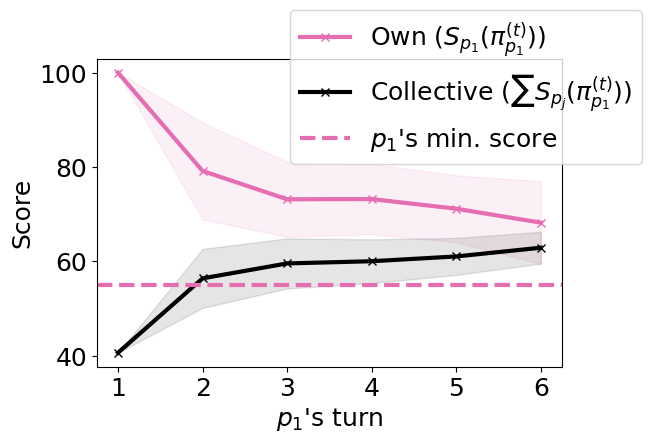

In [28]:

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', label='Own ($S_{p_1}(\pi_{p_1}^{(t)})$)', color='#E56DB1')
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own),\
                  alpha=0.1, color='#E56DB1')

ax1.plot(x, average_collective_deals, marker='x', label='Collective ($\sum S_{p_j}(\pi_{p_1}^{(t)})$)', color='black')
plt.fill_between(x, np.array(average_collective_deals) - np.array(std_avg_deal), np.array(average_collective_deals) + np.array(std_avg_deal),
                  alpha=0.1,color='black')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')
ax1.legend(loc='best',fontsize=18,bbox_to_anchor=(1.2, 1.2))

plt.show()



In [31]:
average_target_agent_score = [np.mean( [suggested['others_scores'][i][0][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][1][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][2][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][3][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][4][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][5][target_agent_idx] for i in range(len(suggested['others_scores']))])]

std_target_agent_score = [np.std( [suggested['others_scores'][i][0][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][1][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][2][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][3][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][4][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][5][target_agent_idx] for i in range(len(suggested['others_scores']))])]

In [32]:
average_greedy_agent_score = [np.mean( [suggested['others_scores'][i][0][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][1][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][2][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][3][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][4][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][5][greedy_agent_idx] for i in range(len(suggested['others_scores']))])]

std_greedy_agent_score = [np.std( [suggested['others_scores'][i][0][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][1][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][2][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][3][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][4][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][5][greedy_agent_idx] for i in range(len(suggested['others_scores']))])]

## Leading agent ($p_1$) suggested deals per rounds and their corresponding score for the enviromental agent ($p_i$)
### Used in the greedy game for evaluation when the enviromental agent is greedy 

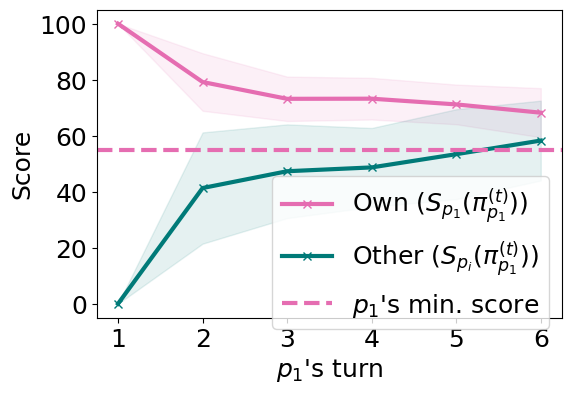

In [35]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', color='#E56DB1',label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)")
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own),\
                  alpha=0.1, color='#E56DB1')


ax1.plot(x, average_greedy_agent_score, marker='x', color='#007A78', label='Other ($S_{p_i}(\pi_{p_1}^{(t)})$)')
plt.fill_between(x, np.array(average_greedy_agent_score) - np.array(std_greedy_agent_score), np.array(average_greedy_agent_score) + np.array(std_greedy_agent_score),
                  alpha=0.1,color='#007A78')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')

ax1.legend(loc='best',fontsize=18,bbox_to_anchor=(1, 0.5))

plt.show()



In [36]:
average_veto_agent_score = [np.mean( [suggested['others_scores'][i][0][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][1][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][2][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][3][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][4][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][5][veto_agent_idx] for i in range(len(suggested['others_scores']))])]

std_veto_agent_score = [np.std( [suggested['others_scores'][i][0][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][1][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][2][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][3][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][4][veto_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][5][veto_agent_idx] for i in range(len(suggested['others_scores']))])]

## Leading agent ($p_1$) suggested deals per rounds and their corresponding score for the veto agent ($p_2$)
### Used to measure the effect of the greedy, sabotaging games on other agents 
### A lower score for $p_2$ might lead to no agreement 

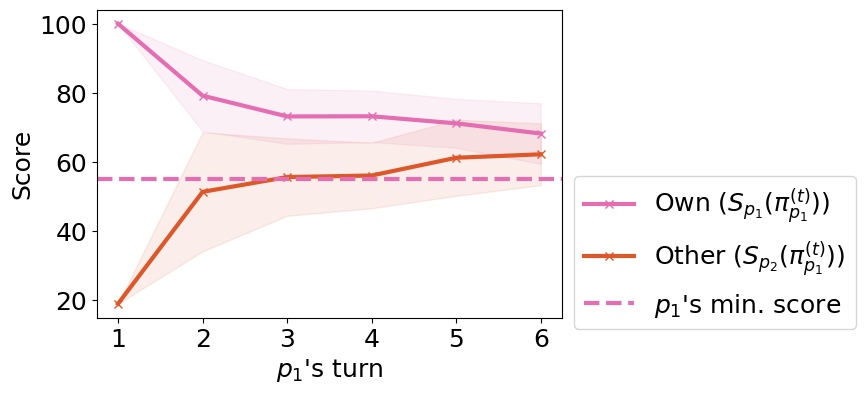

In [38]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', color='#E56DB1',label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)")
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own),\
                  alpha=0.1, color='#E56DB1')


ax1.plot(x, average_veto_agent_score, marker='x', color='#DC582A', label='Other ($S_{p_2}(\pi_{p_1}^{(t)})$)')
plt.fill_between(x, np.array(average_veto_agent_score) - np.array(std_veto_agent_score), np.array(average_veto_agent_score) + np.array(std_veto_agent_score),
                  alpha=0.1,color='#DC582A')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')

ax1.legend(loc='best',fontsize=18,bbox_to_anchor=(1, 0.5))

plt.show()



## Leading agent ($p_1$) suggested deals per rounds and their corresponding score for another agent ($p_v$)
### $p_v$ is assigned as the target in the sabotaging game
### Used to measure the effect of the sabotaging game on the target agent 

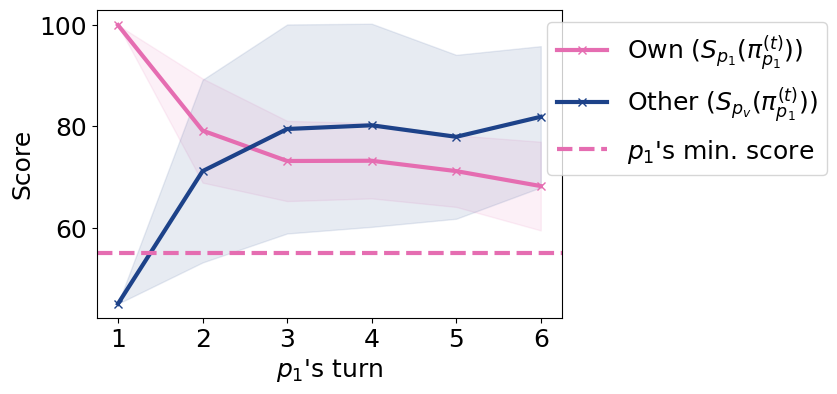

In [41]:


import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', color='#E56DB1', label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)")
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own),\
                  alpha=0.1, color='#E56DB1')


ax1.plot(x, average_target_agent_score, marker='x', color='#1D4289', label='Other ($S_{p_v}(\pi_{p_1}^{(t)})$)')
plt.fill_between(x, np.array(average_target_agent_score) - np.array(std_target_agent_score), np.array(average_target_agent_score) + np.array(std_target_agent_score),
                  alpha=0.1,color='#1D4289')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')

ax1.legend(fontsize=18,bbox_to_anchor=(0.94,1))

plt.show()



## Get suggestions of the greedy/adv agent over rounds. 

In [44]:
adv_suggested = {'own_value':[], 'agree':[], 'avg_value':[], 'others_scores' : []}
for session_i, session in enumerate(deal_values_self):
    session_own = []
    session_avg = []
    session_agree = []
    session_others_scores = []
    if len(session[p_adv]) < 4: continue 
    for i, round_ in enumerate(session[p_adv]): 
        session_own.append(round_[0])
        session_avg.append(round_[2])
        session_agree.append(round_[1])
        session_others_scores.append(round_[-1])
            
        
    adv_suggested['own_value'].append(session_own)
    adv_suggested['avg_value'].append(session_avg)
    adv_suggested['agree'].append(session_agree)
    adv_suggested['others_scores'].append(session_others_scores)
    

    
adv_average_round_own = [np.mean( [adv_suggested['own_value'][i][0] for i in range(len(adv_suggested['own_value']))]),
                 np.mean( [adv_suggested['own_value'][i][1] for i in range(len(adv_suggested['own_value']))]),
                 np.mean( [adv_suggested['own_value'][i][2] for i in range(len(adv_suggested['own_value']))]),
                 np.mean( [adv_suggested['own_value'][i][3] for i in range(len(adv_suggested['own_value']))])]

adv_std_round_own = [np.std( [adv_suggested['own_value'][i][0] for i in range(len(adv_suggested['own_value']))]),
                 np.std( [adv_suggested['own_value'][i][1] for i in range(len(adv_suggested['own_value']))]),
                 np.std( [adv_suggested['own_value'][i][2] for i in range(len(adv_suggested['own_value']))]),
                 np.std( [adv_suggested['own_value'][i][3] for i in range(len(adv_suggested['own_value']))])]

adv_average_collective_deals = [np.mean( [adv_suggested['avg_value'][i][0] for i in range(len(adv_suggested['avg_value']))]),
                 np.mean( [adv_suggested['avg_value'][i][1] for i in range(len(adv_suggested['avg_value']))]),
                 np.mean( [adv_suggested['avg_value'][i][2] for i in range(len(adv_suggested['avg_value']))]),
                 np.mean( [adv_suggested['avg_value'][i][3] for i in range(len(adv_suggested['avg_value']))])]

adv_std_avg_deal = [np.std( [adv_suggested['avg_value'][i][0] for i in range(len(adv_suggested['avg_value']))]),
                 np.std( [adv_suggested['avg_value'][i][1] for i in range(len(adv_suggested['avg_value']))]),
                 np.std( [adv_suggested['avg_value'][i][2] for i in range(len(adv_suggested['avg_value']))]),
                 np.std( [adv_suggested['avg_value'][i][3] for i in range(len(adv_suggested['avg_value']))])]

adv_target_score = [np.mean( [adv_suggested['others_scores'][i][0][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.mean( [adv_suggested['others_scores'][i][1][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.mean( [adv_suggested['others_scores'][i][2][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.mean( [adv_suggested['others_scores'][i][3][target_agent_idx] for i in range(len(adv_suggested['others_scores']))])]

adv_std_target_score = [np.std( [adv_suggested['others_scores'][i][0][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.std( [adv_suggested['others_scores'][i][1][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.std( [adv_suggested['others_scores'][i][2][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.std( [adv_suggested['others_scores'][i][3][target_agent_idx] for i in range(len(adv_suggested['others_scores']))])]


## Graphs for the adv/greedy agent's suggestions, their collective score, and their score wrt the target ($p_v$)

### Used to evaluate the adv/greedy game or a baseline for the cooperative game. 

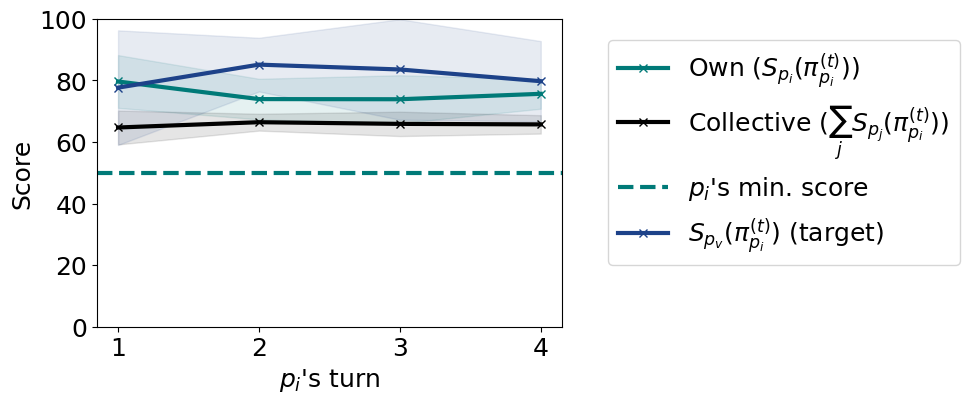

In [46]:

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(adv_average_round_own) + 1)

ax1 = plt.subplot(111)

ax1.plot(x, adv_average_round_own, marker='x', label='Own ($S_{p_i}(\pi_{p_i}^{(t)})$)', color='#007A78')
plt.fill_between(x, np.array(adv_average_round_own) - np.array(adv_std_round_own),\
                 np.array(adv_average_round_own) + np.array(adv_std_round_own),\
                  alpha=0.1, color='#007A78')

ax1.plot(x, adv_average_collective_deals, marker='x', label='Collective ($\sum_j S_{p_j}(\pi_{p_i}^{(t)})$)', color='black')
plt.fill_between(x, np.array(adv_average_collective_deals) - np.array(adv_std_avg_deal), \
                 np.array(adv_average_collective_deals) + np.array(adv_std_avg_deal),
                  alpha=0.1,color='black')


plt.xlabel("$p_i$'s turn")
plt.ylabel('Score')
plt.ylim((0, 100))
plt.axhline(y=50, label="$p_i$'s min. score", color='#007A78', linestyle='--')


ax1.plot(x, adv_target_score, marker='x', label="$S_{p_v}(\pi_{p_i}^{(t)})$ (target)", color='#1D4289')
plt.fill_between(x, np.array(adv_target_score) - np.array(adv_std_target_score), \
                 np.array(adv_target_score) + np.array(adv_std_target_score),
                  alpha=0.1,color='#1D4289')


ax1.legend(fontsize=18,loc=(1.1, 0.2))
plt.show()



## Histogram of the votes of agents per issue. 

### $p_1$ votes for the environmental protection issues. 
### $p_i$ (the environmental agent) for the environmental protection issues.
### Used to evaluate the consistency of agents w.r.t. their payoffs (e.g., $p_1$ should vote less frequently for high protection levels)

In [52]:

def get_votes_for_options(answers, options_to_count, agents_names):
    for round_ in answers['rounds']:
        if len(round_) != 2: continue 
        name,answer = round_
        deal, issues_suggested = extract_deal(answer)
        if issues_suggested < 5: continue
        for option_ in options_to_count:
            if option_ in deal:
                count_options_per_agent[name][option_] += 1
    
    return 

In [53]:
options_to_count = ['A1','A2','A3','B1','B2','B3']
count_options_per_agent = {agent_: {option_:0 for option_ in options_to_count} for agent_ in scores.keys()}
for file_ in answers_files:
    answers = json.load(open(file_))    
    get_votes_for_options(answers, options_to_count, scores.keys())

In [54]:
count_env_options_leading_agent = [ count_options_per_agent['SportCo']['A1'] + count_options_per_agent['SportCo']['B1'] , \
count_options_per_agent['SportCo']['A2'] + count_options_per_agent['SportCo']['B2'] , \
count_options_per_agent['SportCo']['A3'] + count_options_per_agent['SportCo']['B3'] ]
count_env_options_leading_agent =  np.array(count_env_options_leading_agent) * 100 / sum(count_env_options_leading_agent)

count_env_options_env_agent = [count_options_per_agent['The Environmental League']['A1'] + count_options_per_agent['The Environmental League']['B1'] , \
count_options_per_agent['The Environmental League']['A2'] + count_options_per_agent['The Environmental League']['B2'] , \
count_options_per_agent['The Environmental League']['A3'] + count_options_per_agent['The Environmental League']['B3'] ]

count_env_options_env_agent =  np.array(count_env_options_env_agent) * 100 / sum(count_env_options_env_agent)


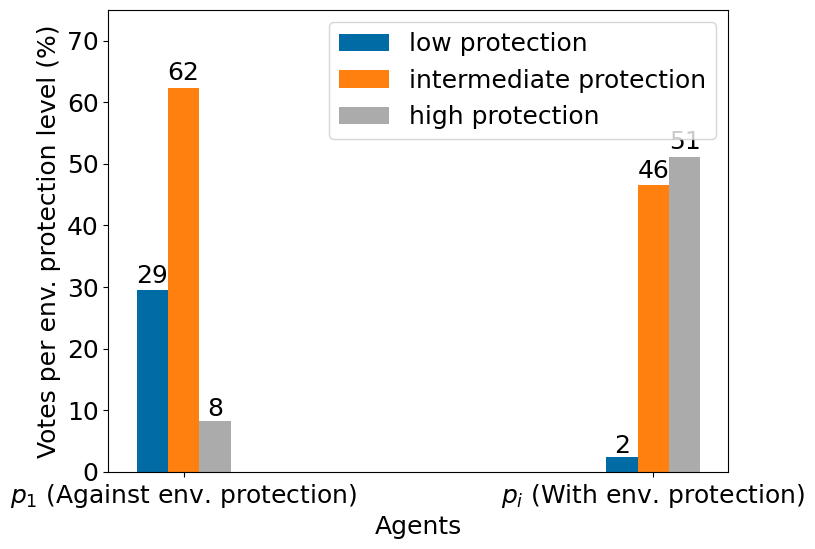

In [55]:

import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
        

x_labels = ['$p_1$ (Against env. protection)', '$p_i$ (With env. protection)']
labels = ['low protection', 'intermediate protection', 'high protection']


plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(figsize=(8,6))

width = 0.2
x_pos = [0, 3]
bars = []
for i in range(3):
    bars.append(ax.bar([x + i * width for x in x_pos], [count_env_options_leading_agent[i], count_env_options_env_agent[i]], width=width, label=labels[i]))

ax.set_xticks([x + width for x in x_pos])
ax.set_xticklabels(x_labels)
ax.set_xlabel('Agents')


ax.set_ylabel('Votes per env. protection level (%)')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(bars[0])
autolabel(bars[1])
autolabel(bars[2])
plt.ylim((0, 75))

# Add a legend
ax.legend(loc='best')

plt.show()
